In [13]:
# pip install lightgbm

In [32]:
import pickle
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import numpy as np
import warnings
warnings.simplefilter('ignore')

In [33]:
train = pickle.load(open('data/processed_train3.pkl', 'rb'))
test = pickle.load(open('data/processed_test3.pkl', 'rb'))

In [34]:
print(train.shape)
print(test.shape)

train = train[train.keisaiday >= 0].reset_index(drop=True)
test = test[test.keisaiday >= 0].reset_index(drop=True)

train = train[train.keisaiday <= 180].reset_index(drop=True)
test = test[test.keisaiday <= 180].reset_index(drop=True)
print(train.shape)
print(test.shape)


(458347, 18)
(114482, 17)
(442031, 18)
(110388, 17)


In [35]:
# category_cols = ['n_car_cd','n_p_katashiki_id','n_p_grade_id','pre_n','repair_flag', 'client_dealer_flag', 'color_cd2', 'sunroof', 'leather_seats', 'n_car_cd + n_p_katashiki_id + nenshiki']
category_cols = ['pre_n','repair_flag', 'zan_syaken+α(seibi)', 'seibi', 'client_dealer_flag', 'color_cd2', 'sunroof', 'leather_seats', 'n_car_cd + n_p_katashiki_id + nenshiki']

int_clos = ['price','e_distance','exhaust_nm_cc','zan_syaken', 'nenshiki','keisaiday']

train[category_cols] = train[category_cols].astype('category')
train[int_clos] = train[int_clos].astype('int')

In [36]:
use_cols = category_cols + int_clos
train = train[category_cols + int_clos]

In [37]:
train['keisaiday']= np.log(train['keisaiday']+1)

In [38]:
# print(train.shape)
# train = train[train.groupby('n_car_cd + n_p_katashiki_id + nenshiki')['n_car_cd + n_p_katashiki_id + nenshiki'].transform('count') >= 30]
# print(train.shape)

In [39]:
sK_fold = StratifiedKFold(n_splits=3, shuffle=True,  random_state=0)

for train_index, eval_index in sK_fold.split(list(range(len(train))), train['n_car_cd + n_p_katashiki_id + nenshiki']):

    lgb_train = lgb.Dataset(train.iloc[train_index, :].drop(columns='keisaiday')
                            , train.iloc[train_index, :]['keisaiday']
                            , categorical_feature=category_cols
                           )
    lgb_eval = lgb.Dataset(train.iloc[eval_index, :].drop(columns='keisaiday')
                           , train.iloc[eval_index, :]['keisaiday']
                           , reference=lgb_train,
                           categorical_feature=category_cols
                          )

    # パラメータを設定
    params = {'task': 'train',                # 学習、トレーニング ⇔　予測predict
              'boosting_type': 'gbdt',        # 勾配ブースティング
              'objective': 'regression',      # 目的関数：多値分類、マルチクラス分類
              'metric': 'mae',                # 目的変数のクラス数
              'learning_rate': 0.05,          # 学習率（初期値0.1）             # 決定木の複雑度を調整（初期値31）
             }

    evaluation_results = {}  

    model = lgb.train(params,                                   # 上記で設定したパラメータ
                          lgb_train,                                # 使用するデータセット
                          num_boost_round=1000,                     # 学習の回数
                          valid_names=['train', 'valid'],           # 学習経過で表示する名称
                          valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
                          evals_result=evaluation_results,          # 学習の経過を保存
                          categorical_feature=category_cols, # カテゴリー変数を設定
                          early_stopping_rounds=100,                 # アーリーストッピング# 学習
                          verbose_eval=50)               

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10011
[LightGBM] [Info] Number of data points in the train set: 294687, number of used features: 14
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3.067802
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 0.78158	valid's l1: 0.794412
[100]	train's l1: 0.763919	valid's l1: 0.7884
[150]	train's l1: 0.752816	valid's l1: 0.78612
[200]	train's l1: 0.744079	valid's l1: 0.784708
[250]	train's l1: 0.736796	valid's l1: 0.783976
[300]	train's l1: 0.730953	valid's l1: 0.783739
[350]	train's l1: 0.725759	valid's l1: 0.783544
[400]	train's l1: 0.721015	valid's l

In [ ]:
test['n_car_cd + n_p_katashiki_id + nenshiki'] = test['n_car_cd'].astype(str) + '+' + test['n_p_katashiki_id'].astype(str) + '+' +  test['n_p_grade_id'].astype(str)

In [47]:
test[category_cols] = test[category_cols].astype('category')
test[int_clos] = test[int_clos].astype('int')

test = test[category_cols + int_clos]

In [48]:
y_pred = model.predict(test.drop(columns='keisaiday'), num_iteration=model.best_iteration)
y_pred = np.exp(y_pred)

test['pred'] = y_pred

In [49]:
from sklearn.metrics import mean_absolute_error

In [50]:
mean_absolute_error(test['pred'],test['keisaiday'] )

22.21787098033251

In [45]:
import matplotlib.pyplot as plt

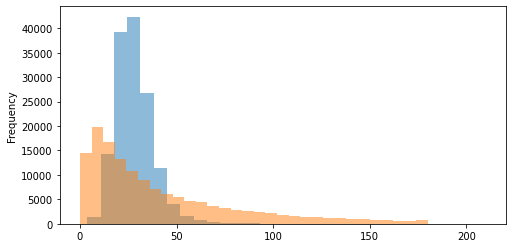

In [17]:
test['pred'].plot.hist(bins=30,alpha=0.5, figsize=(8, 4))
test['keisaiday'].plot.hist(bins=30,alpha=0.5, figsize=(8, 4))
plt.show()

<AxesSubplot:ylabel='Frequency'>

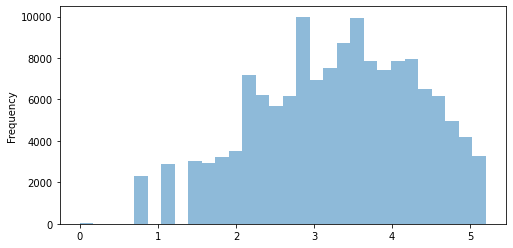

In [18]:
np.log(test['keisaiday']+1).plot.hist(bins=30,alpha=0.5, figsize=(8, 4))

<AxesSubplot:ylabel='Frequency'>

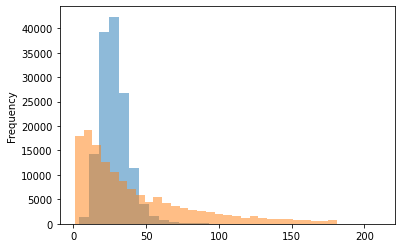

In [19]:
test['pred'].plot.hist(bins=30,alpha=0.5)
np.exp(np.log(test['keisaiday']+1)).plot.hist(bins=30,alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

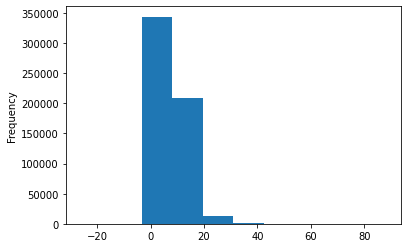

In [20]:
train.nenshiki.plot.hist()

In [21]:
test.pred.median()

26.879815510193144

<AxesSubplot:ylabel='Frequency'>

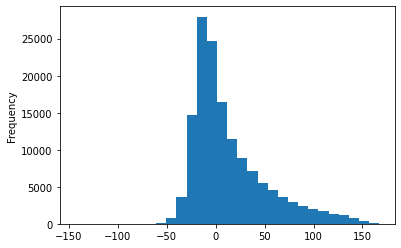

In [22]:
(test.keisaiday - test.pred).plot.hist(bins=30)

In [23]:
test[(test.pred>=0) & (test.pred<5)].keisaiday.median()

1.5

In [24]:
test[(test.pred>=5) & (test.pred<10)].keisaiday.median()

7.0

In [25]:
test[(test.pred>=10) & (test.pred<15)].keisaiday.median()

14.0

In [26]:
test[(test.pred>=15) & (test.pred<20)].keisaiday.median()

18.0

In [27]:
test[(test.pred>=20) & (test.pred<25)].keisaiday.median()

23.0

In [28]:
test[(test.pred>=25) & (test.pred<30)].keisaiday.median()

28.0

In [29]:
test[(test.pred>=30) & (test.pred<35)].keisaiday.median()

34.0

In [30]:
test[(test.pred>=35) & (test.pred<40)].keisaiday.median()

40.0

In [31]:
test[(test.pred>=40) & (test.pred<45)].keisaiday.median()

43.0

<AxesSubplot:>

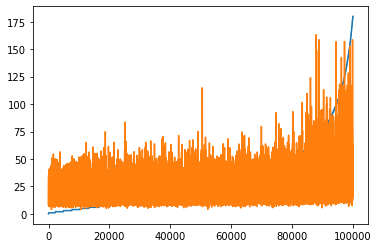

In [1507]:
test.sort_values(by='keisaiday').reset_index()['keisaiday'].plot()
test.sort_values(by='keisaiday').reset_index()['pred'].plot()

In [1508]:
from sklearn.metrics import mean_absolute_error
print(test.shape)
test = test[test.groupby('n_car_cd + n_p_katashiki_id + nenshiki')['n_car_cd + n_p_katashiki_id + nenshiki'].transform('count') >= 30]
print(test.shape)
mae = mean_absolute_error(test.pred ,test.keisaiday)

(99974, 16)
(45185, 16)


In [1509]:
mae

20.158850791333865

In [1510]:
test[(test.keisaiday-test.pred.astype(int)).abs() <= 14]

,pre_n,repair_flag,zan_syaken+α(seibi),seibi,client_dealer_flag,color_cd2,sunroof,leather_seats,n_car_cd + n_p_katashiki_id + nenshiki,price,e_distance,exhaust_nm_cc,zan_syaken,nenshiki,keisaiday,pred
10,福岡県,1,1.0,1,0,35,0,0,10502014+19+39,260000,115767,660,0,11,38,28.547815
20,静岡県,1,0.0,0,0,30,0,0,10201027+16+16,298000,44499,1300,0,11,26,24.401470
22,大阪府,1,0.0,1,0,50,0,0,10151037+26+106,150000,117906,660,747,9,22,26.712379
29,神奈川県,1,0.0,1,1,20,0,0,10202030+19+123,2100000,1255,1500,534,2,23,12.081953
35,岡山県,1,1.0,1,0,10,0,0,10502014+19+-1,150000,162000,660,0,12,8,15.167521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99959,愛知県,1,0.0,1,0,25,0,0,10152036+36+92,1498000,20000,2000,0,5,6,13.683088
99960,千葉県,1,0.0,1,1,60,0,0,10201029+33+89,450000,53380,1500,370,10,26,18.115932
99962,大阪府,1,0.0,1,0,55,0,0,10553003+53+59,248000,136000,660,155,7,11,21.026890
99966,北海道,1,0.0,1,0,40,0,0,10151042+26+240,299000,97000,1200,400,5,3,14.211572


In [1389]:
n=6000
test.sort_values(by=['n_car_cd + n_p_katashiki_id + nenshiki','e_distance','price']).iloc[n:n+100].head(30)

,pre_n,repair_flag,zan_syaken+α(seibi),seibi,client_dealer_flag,color_cd2,sunroof,leather_seats,n_car_cd + n_p_katashiki_id + nenshiki,price,e_distance,exhaust_nm_cc,zan_syaken,nenshiki,keisaiday,pred
68753,大阪府,1,0.0,1,0,40,0,0,10101043+16+-1,790000,80000,2000,437,21,163,24.979776
15622,東京都,1,0.0,2,0,30,0,0,10101043+16+-1,720000,145000,2000,443,16,29,22.201483
49032,沖縄県,1,1.0,1,0,40,0,0,10101043+16+43,390000,154331,2000,0,21,87,32.198665
47009,和歌山県,1,0.0,0,1,40,0,0,10101043+16+46,935000,17000,2000,475,17,4,14.536956
53281,埼玉県,2,0.0,1,0,40,0,0,10101043+16+46,1098000,100157,2000,345,18,11,25.818425
62670,沖縄県,2,0.0,1,0,40,0,0,10101043+16+49,550000,152127,2000,513,17,67,31.147136
82222,宮城県,1,0.0,0,0,20,0,0,10101043+16+50,640000,162000,2000,736,16,8,25.042709
17157,愛知県,1,0.0,1,0,30,0,0,10101043+16+51,699000,137310,2000,646,17,6,23.970240
50589,神奈川県,1,1.0,1,0,40,0,0,10101043+16+53,1590000,45351,2000,0,22,11,42.488302
27474,大阪府,2,0.0,2,0,30,0,0,10101043+16+53,898000,58104,2000,0,19,63,31.772268


In [1390]:
import matplotlib.pyplot as  plt
import pandas as pd

<AxesSubplot:>

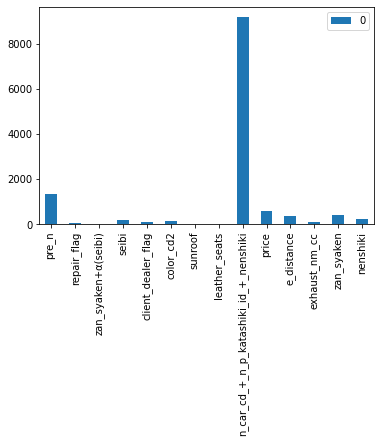

In [1391]:
pd.DataFrame(model.feature_importance(),index=model.feature_name()).plot.bar()

In [ ]:
train